In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

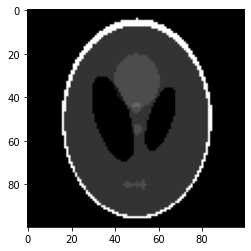

In [102]:
shepp = shepp_logan_phantom()
shepp = shepp[::4,::4]
plt.imshow(shepp,cmap='gray')
plt.show()

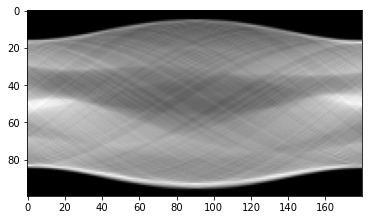

(100, 180)


In [276]:
theta = np.arange(0,180,1)
sinogram = radon(shepp, theta=theta)
plt.imshow(sinogram,cmap='gray')
plt.show()
print(np.shape(sinogram))

In [118]:
#forward transform
def multiplyA(x_vec,detec_dim,image_dimensions,num_angles,im_pix_wid):
    
    de_pix_wid=im_pix_wid
    
    m = image_dimensions[0]
    n = image_dimensions[1]
    N = m*n
    
    k = int(np.floor(detec_dim*np.sqrt(2)) + 1)
    if k%2 == 1:
        k = k+1
        
    k = detec_dim
    
    xs = im_pix_wid*(0.5 + np.arange(int(-m/2),int(m/2)))
    xs= xs.reshape(1,m)
    xs = np.repeat(a = xs, repeats = n, axis = 0)
    xs = np.ndarray.flatten(xs)
    
    ys = im_pix_wid*(0.5 + np.arange(int(-n/2),int(n/2)))
    ys = ys.reshape(1,n)
    ys = np.repeat(a = ys, repeats = m, axis = 1)
    ys = np.ndarray.flatten(ys)
    
    
    
    ds = de_pix_wid*(0.5 + np.arange(int(-k/2),int(k/2)))
    thetas = np.arange(0,num_angles)*np.pi/num_angles
    phis = thetas
    
    proj = np.zeros(num_angles*k)
    
    for i in range(num_angles):
        x_phi = xs*np.cos(phis[i]) + ys*np.sin(phis[i])
        p_phi = (np.floor(2*x_phi/de_pix_wid) + k - 1)/2
        p_phi = p_phi.astype(int)
        
        
        for j in range(N):
            
            if p_phi[j] + 1 == np.size(ds):
                weight1 = (ds[p_phi[j]] + de_pix_wid - x_phi[j])/de_pix_wid
                proj[i*k + p_phi[j]] += x_vec[j]*weight1
            elif p_phi[j] + 1 < np.size(ds):
                weight1 = (ds[p_phi[j] + 1] - x_phi[j])/de_pix_wid
                weight2 = 1 - (ds[p_phi[j] + 1] - x_phi[j])/de_pix_wid
                
                
                proj[i*k + p_phi[j]] += x_vec[j]*weight1
                proj[i*k + p_phi[j] + 1] += x_vec[j]*weight2
            
            
    return proj

In [121]:
#like the original, but better...
def multiplyA2(x_vec,detec_dim,image_dimensions,num_angles,im_pix_wid):
    
    de_pix_wid=im_pix_wid
    
    m = image_dimensions[0]
    n = image_dimensions[1]
    N = m*n
    
    k = int(np.floor(detec_dim*np.sqrt(2)) + 1)
    if k%2 == 1:
        k = k+1
        
    k = detec_dim
    
    xs = im_pix_wid*(0.5 + np.arange(int(-m/2),int(m/2)))
    xs= xs.reshape(1,m)
    xs = np.repeat(a = xs, repeats = n, axis = 0)
    xs = np.ndarray.flatten(xs)
    
    ys = im_pix_wid*(0.5 + np.arange(int(-n/2),int(n/2)))
    ys = ys.reshape(1,n)
    ys = np.repeat(a = ys, repeats = m, axis = 1)
    ys = np.ndarray.flatten(ys)
    
    
    
    ds = de_pix_wid*(0.5 + np.arange(int(-k/2),int(k/2)))
    thetas = np.arange(0,num_angles)*np.pi/num_angles
    phis = thetas
    
    
    proj = np.zeros(num_angles*k)
    

    x_phi = xs*np.cos(phis[:,np.newaxis]) + ys*np.sin(phis[:,np.newaxis])
    p_phi = (np.floor(2*x_phi/de_pix_wid) + k - 1)/2
    p_phi = p_phi.astype(int)
    
    
    
    
    for i in range(num_angles):
        for j in range(N):
            
            if p_phi[i,j] + 1 == np.size(ds):
                weight1 = (ds[p_phi[i,j]] + de_pix_wid - x_phi[i,j])/de_pix_wid
                proj[i*k + p_phi[j]] += x_vec[j]*weight1
            elif p_phi[i,j] + 1 < np.size(ds):
                weight1 = (ds[p_phi[i,j] + 1] - x_phi[i,j])/de_pix_wid
                weight2 = 1 - (ds[p_phi[i,j] + 1] - x_phi[i,j])/de_pix_wid
                
                proj[i*k + p_phi[i,j]] += x_vec[j]*weight1
                proj[i*k + p_phi[i,j] + 1] += x_vec[j]*weight2
            
            
    return proj

In [277]:
m = 100
T = 180

xvec = np.reshape(shepp,(np.size(shepp),))
projectionsflat = multiplyA2(xvec,2*m,[m,m],T,im_pix_wid=1)

projections = np.reshape(projectionsflat,(newdim,T),order='F')
projections = np.flip(projections, axis=0)
projections = np.flip(projections, axis=1)

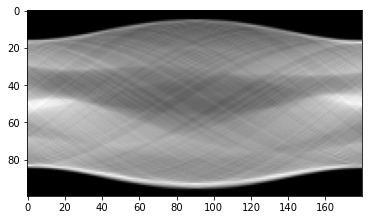

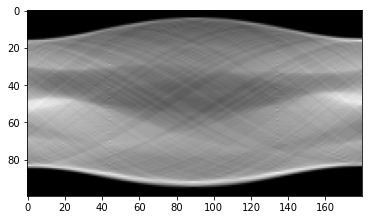

27.632019488286307
26.34286234419511
0.0
0.0


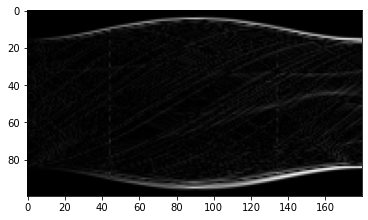

17.867699776011722
0.7738828833083117


In [278]:
newdim = 2*m

plt.imshow(sinogram,cmap='gray')
plt.show()

plt.imshow(projections[50:150],cmap='gray')
plt.show()
print(np.max(projections))
print(np.max(sinogram))
print(np.min(projections))
print(np.min(sinogram))

plt.imshow(abs(projections[50:150] - sinogram),cmap='gray')
plt.show()

print(np.max(abs(projections[50:150] - sinogram)))
print(np.sum(abs(projections[50:150] - sinogram))/np.size(sinogram))



In [214]:
def grad_descent_retrieval(projections,image_dimensions,detec_dim,num_angles,im_pix_wid):
    
    de_pix_wid=im_pix_wid
    
    m = image_dimensions[0]
    n = image_dimensions[1]
    N = m*n
    
    guess = np.zeros((N,))
    
    k = int(np.floor(detec_dim*np.sqrt(2)) + 1)
    if k%2 == 1:
        k = k+1
        
    k = detec_dim
    
    xs = im_pix_wid*(0.5 + np.arange(int(-m/2),int(m/2)))
    xs= xs.reshape(1,m)
    xs = np.repeat(a = xs, repeats = n, axis = 0)
    xs = np.ndarray.flatten(xs)
    
    ys = im_pix_wid*(0.5 + np.arange(int(-n/2),int(n/2)))
    ys = ys.reshape(1,n)
    ys = np.repeat(a = ys, repeats = m, axis = 1)
    ys = np.ndarray.flatten(ys)
    
    ds = de_pix_wid*(0.5 + np.arange(int(-k/2),int(k/2)))
    phis = np.arange(0,num_angles)*np.pi/num_angles
    
    proj = np.zeros(num_angles*k)

    x_phi = xs*np.cos(phis[:,np.newaxis]) + ys*np.sin(phis[:,np.newaxis])
    p_phi = (np.floor(2*x_phi/de_pix_wid) + k - 1)/2
    p_phi = p_phi.astype(int)
    
    weight1 = np.zeros(np.shape(x_phi))
    
    
    for i in range(num_angles):
        for j in range(N):
            
            weight1[i,j] = (ds[p_phi[i,j]] + de_pix_wid - x_phi[i,j])/de_pix_wid
            
    weight2 = 1 - weight1
    
    
    for step in range(50):
        print(f'iteration = {step}')
        
        proj = np.zeros(np.shape(projections))
        
        if step != 0:  
            
            #multiply by A
            
            for i in range(num_angles):
                for j in range(N):

                    if p_phi[i,j] + 1 == np.size(ds):
                        proj[i*k + p_phi[i,j]] += guess[j]*weight1[i,j]
                    elif p_phi[i,j] + 1 < np.size(ds):
                        proj[i*k + p_phi[i,j]] += guess[j]*weight1[i,j]
                        proj[i*k + p_phi[i,j] + 1] += guess[j]*weight2[i,j]


        r = projections - proj
        
        image = np.reshape(guess,(m,n),order='C')
        plt.imshow(image,cmap='gray')
        plt.show()
        
        print(np.sum(abs(r))/np.size(r))
        
        image_r = np.reshape(r,(k,num_angles),order='F')
        image_r = np.flip(image_r, axis=0)
        image_r = np.flip(image_r, axis=1)
        
        plt.imshow(abs(image_r),cmap='gray')
        plt.show()
        
        print(np.dot(r,r)/np.dot(projections,projections))

        if np.dot(r,r) < np.dot(projections,projections)*1e-3:
            return guess

        direction = np.zeros((N,))

        #multiply by A^t
        for i in range(num_angles):
            for j in range(N):
                if p_phi[i,j] + 1 == np.size(ds):
                    direction[j] += weight1[i,j]*r[i*k + p_phi[i,j]]
                elif p_phi[i,j] + 1 < np.size(ds):
                    direction[j] += weight1[i,j]*r[i*k + p_phi[i,j]] + weight2[i,j]*r[i*k + p_phi[i,j] + 1]

        Adirection = np.zeros(np.shape(projections))

        #multiply the gradient of f by A for step size
        for i in range(num_angles):
            for j in range(N):

                if p_phi[i,j] + 1 == np.size(ds):
                    Adirection[i*k + p_phi[i,j]] += direction[j]*weight1[i,j]
                elif p_phi[i,j] + 1 < np.size(ds):
                    Adirection[i*k + p_phi[i,j]] += direction[j]*weight1[i,j]
                    Adirection[i*k + p_phi[i,j] + 1] += direction[j]*weight2[i,j]

        directiondot = np.dot(direction,direction)
        Adirectiondot = np.dot(Adirection,Adirection)

        stepsize = directiondot/Adirectiondot

        guess = guess + stepsize*direction

    print('didnt work :(')
    return guess

iteration = 0


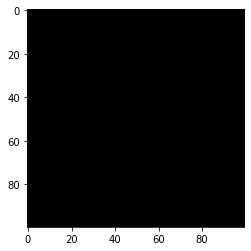

6.205039215686274


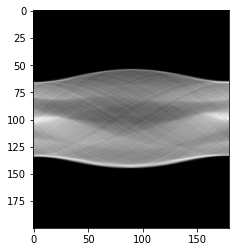

1.0
iteration = 1


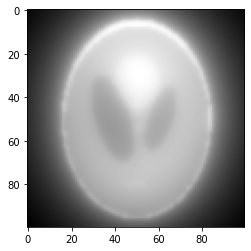

1.891238795962762


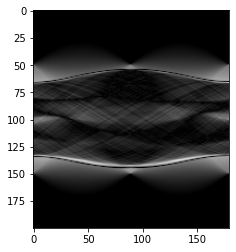

0.09642777627109667
iteration = 2


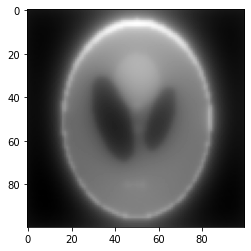

0.9651024537363572


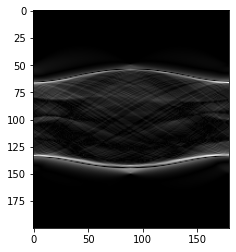

0.0354881066391199
iteration = 3


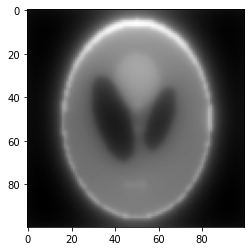

0.7654727855202799


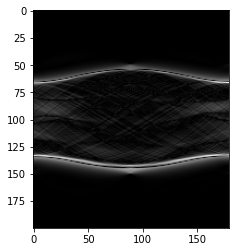

0.026338902920152035
iteration = 4


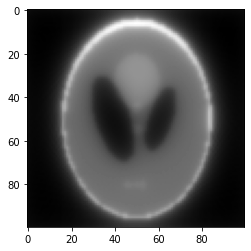

0.6589001409338197


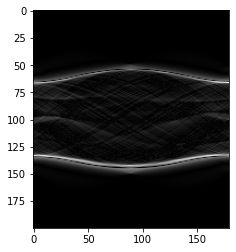

0.021487965583329976
iteration = 5


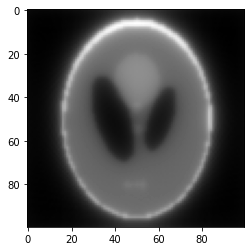

0.5817449827034009


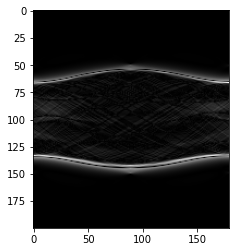

0.018194753700060816
iteration = 6


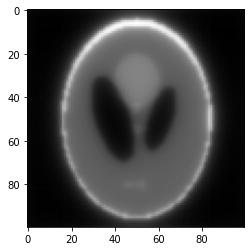

0.5298301932724299


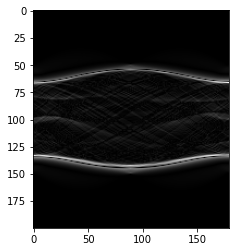

0.01565582360772363
iteration = 7


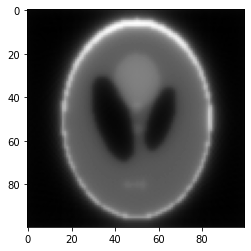

0.4793888920382856


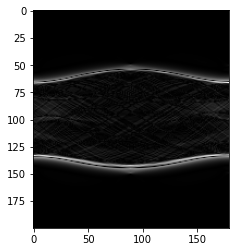

0.013652590564884461
iteration = 8


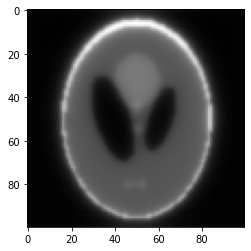

0.445531262352219


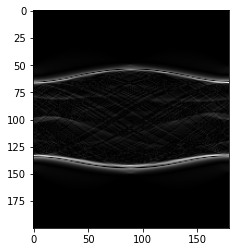

0.012026871298572243
iteration = 9


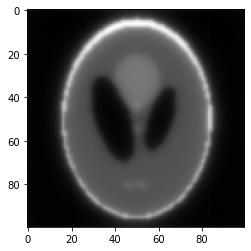

0.40959588727632124


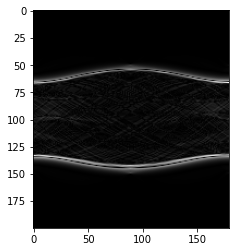

0.010690032946721573
iteration = 10


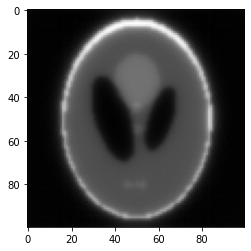

0.38641829356879215


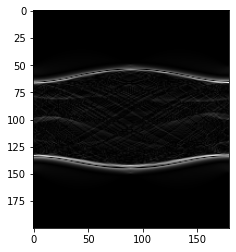

0.009570847752112773
iteration = 11


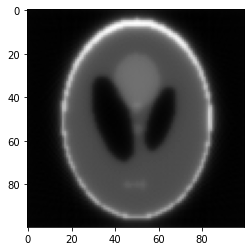

0.35862648286958915


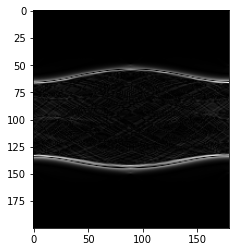

0.00862518275669171
iteration = 12


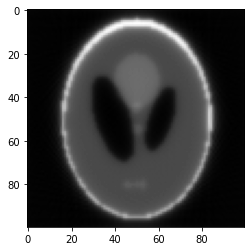

0.3427382483779352


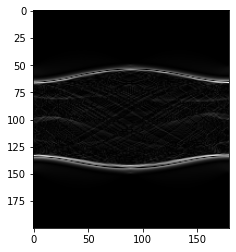

0.00781568777461566
iteration = 13


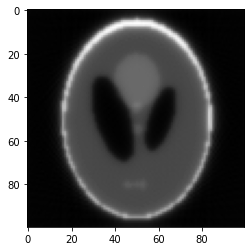

0.31956891637210455


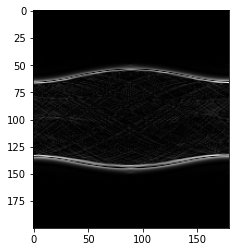

0.007117952778030367
iteration = 14


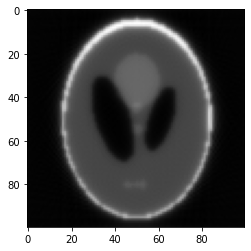

0.3088389506365735


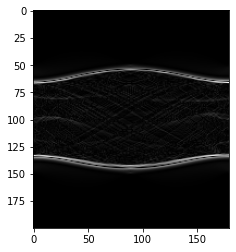

0.006510587649667903
iteration = 15


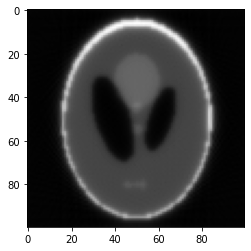

0.28885227420496823


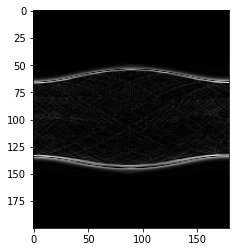

0.00597905236029675
iteration = 16


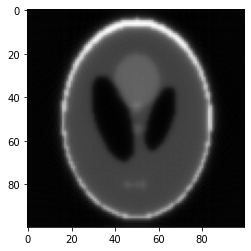

0.2816676847504978


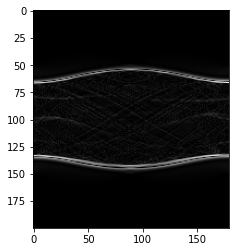

0.005510267451632664
iteration = 17


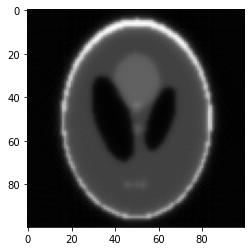

0.26421555206359537


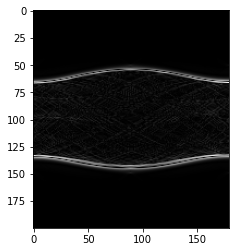

0.005095056284701261
iteration = 18


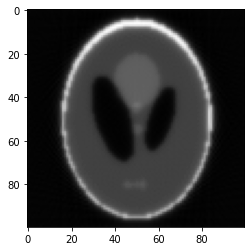

0.25937044486432725


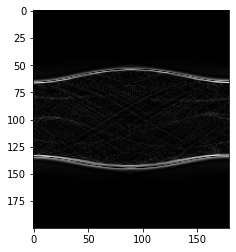

0.0047249917468714046
iteration = 19


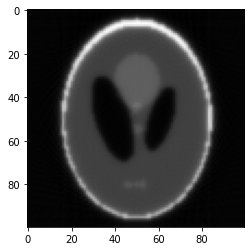

0.24391870235259705


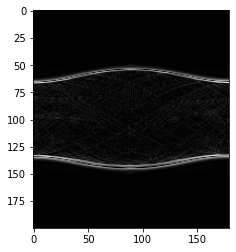

0.00439400774681706
iteration = 20


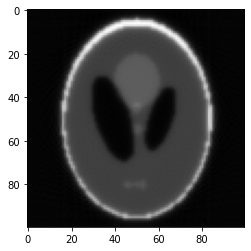

0.24066898755992766


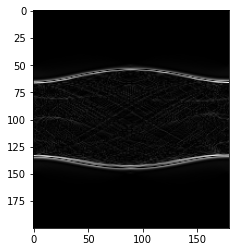

0.00409643964617365
iteration = 21


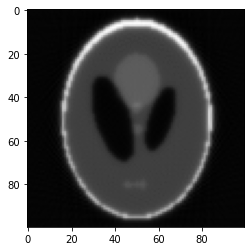

0.22692337706254223


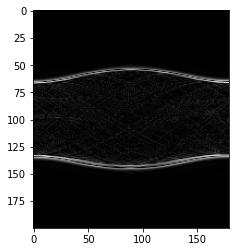

0.003828125028776656
iteration = 22


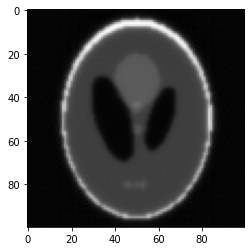

0.22479453512304726


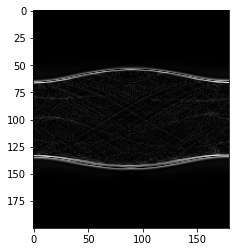

0.0035851227725076295
iteration = 23


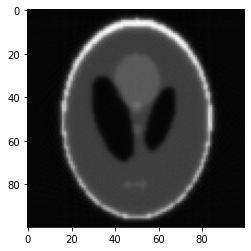

0.21240381505559688


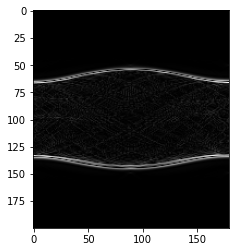

0.0033644887473526144
iteration = 24


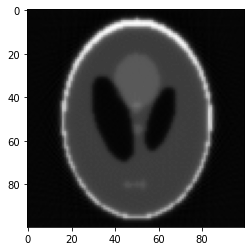

0.21112014967845733


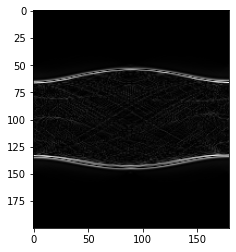

0.003163402679184942
iteration = 25


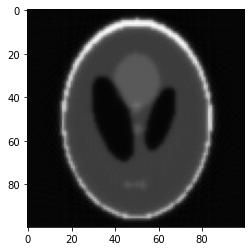

0.19989012357801716


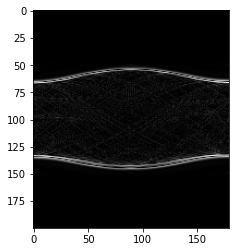

0.0029797294312326416
iteration = 26


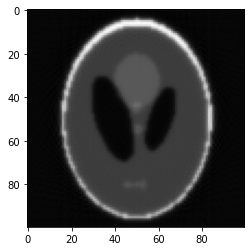

0.19919406383711613


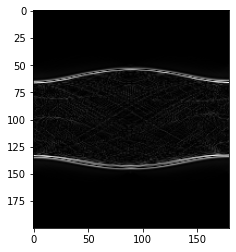

0.00281140321368074
iteration = 27


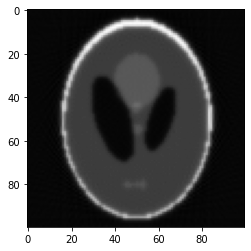

0.1890427923985267


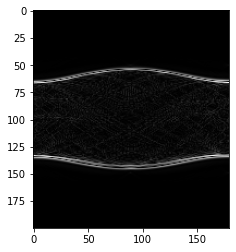

0.0026568427401319305
iteration = 28


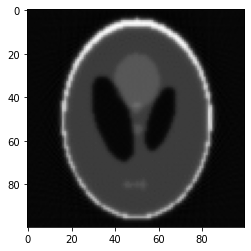

0.1887299770678211


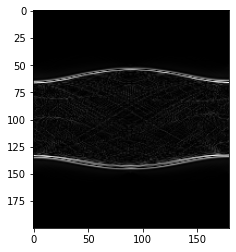

0.0025145048189697356
iteration = 29


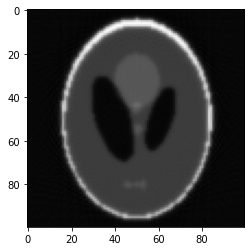

0.17946187841754463


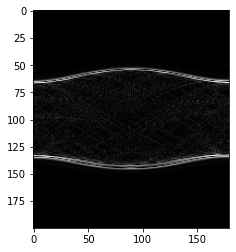

0.0023831970963141508
iteration = 30


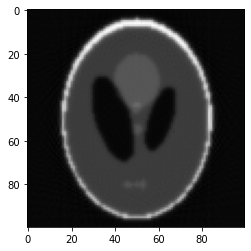

0.17950889360049208


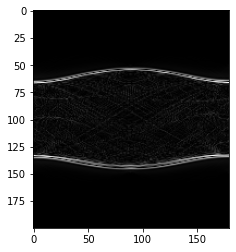

0.002261747105869333
iteration = 31


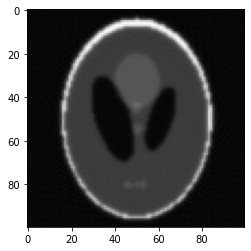

0.170910056782839


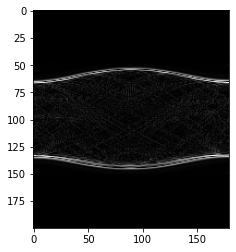

0.002149241543077943
iteration = 32


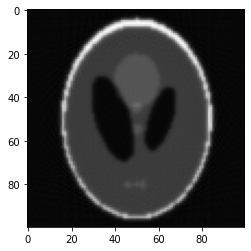

0.1712573202888296


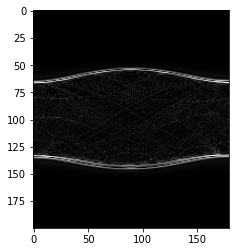

0.0020447763039990346
iteration = 33


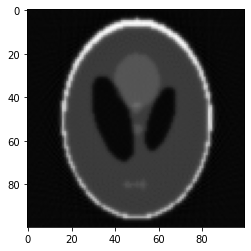

0.1632630598122002


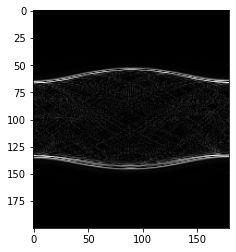

0.001947642029485052
iteration = 34


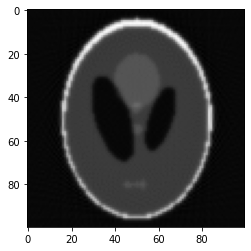

0.16379230763442204


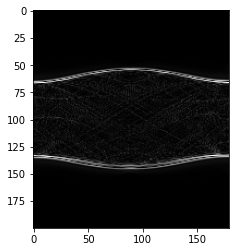

0.0018571323006126253
iteration = 35


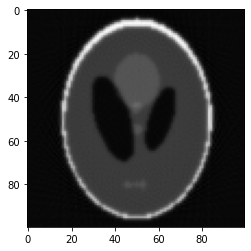

0.15639789371062512


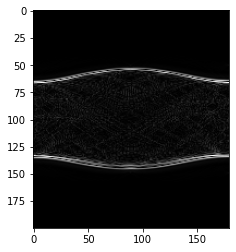

0.0017726892478641641
iteration = 36


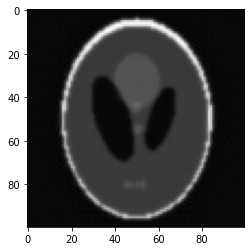

0.1570099943262874


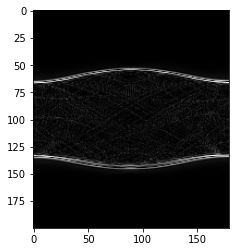

0.0016937543265024436
iteration = 37


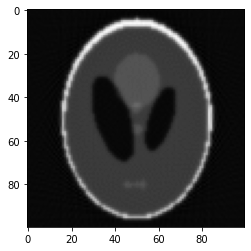

0.15015703418657866


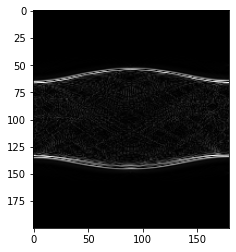

0.0016198838282796653
iteration = 38


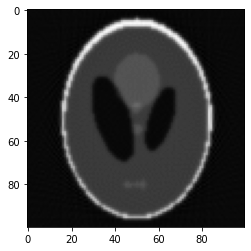

0.1507945465763537


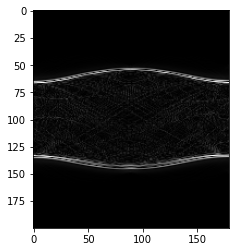

0.0015506313498633018
iteration = 39


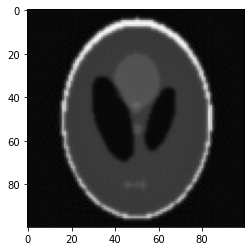

0.14443997733376393


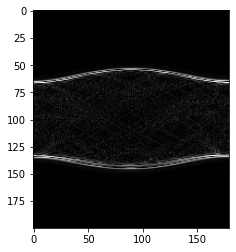

0.0014856403410266064
iteration = 40


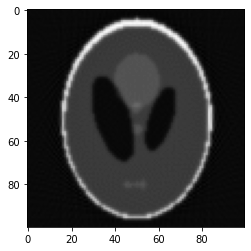

0.1450816709649393


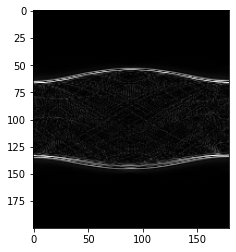

0.0014245505030443773
iteration = 41


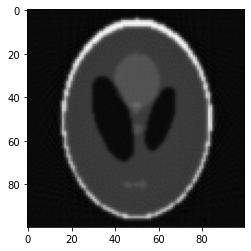

0.13916298964107354


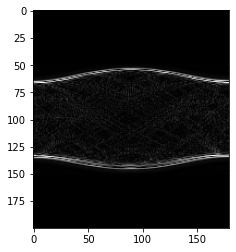

0.0013670726209474055
iteration = 42


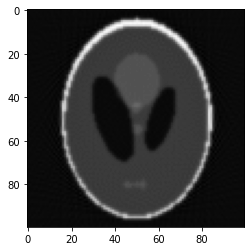

0.13979112697127533


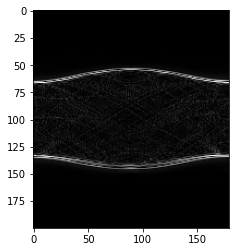

0.001312913261946921
iteration = 43


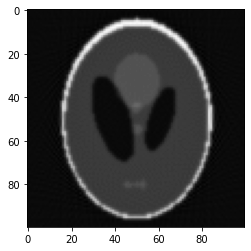

0.13429813154516693


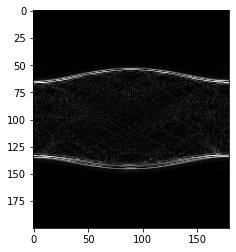

0.0012618358000816338
iteration = 44


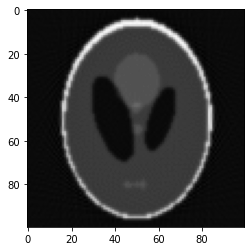

0.1348858969349769


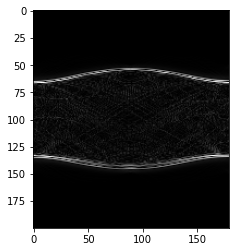

0.0012135992716284165
iteration = 45


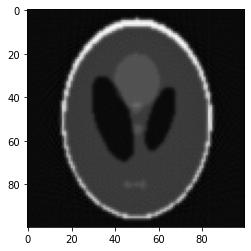

0.1297835977110993


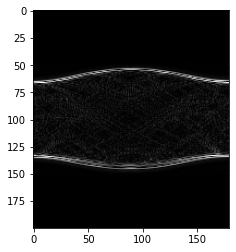

0.0011680085356898084
iteration = 46


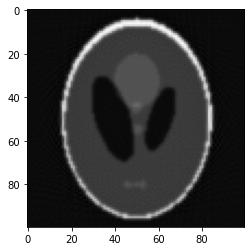

0.13033974303145288


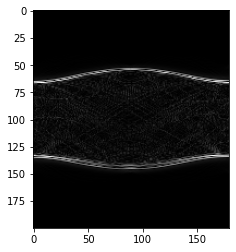

0.0011248641980274908
iteration = 47


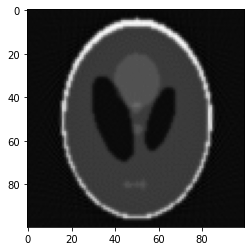

0.125574373405832


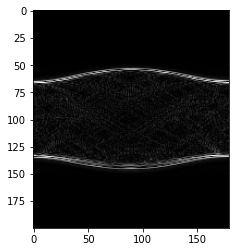

0.0010840041473295782
iteration = 48


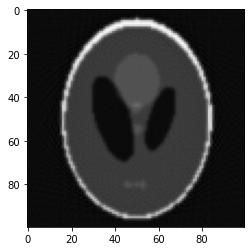

0.12610859778332584


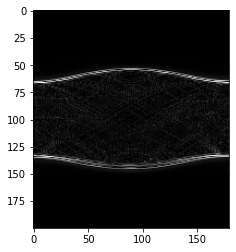

0.0010452622178847442
iteration = 49


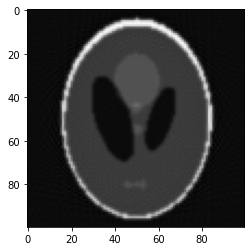

0.12163860529440777


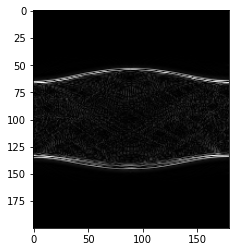

0.0010085028220739717
didnt work :(


In [279]:
recon = grad_descent_retrieval(projectionsflat,[m,m],2*m,T,im_pix_wid=1)
recon = np.reshape(recon,(m,m),order='C')

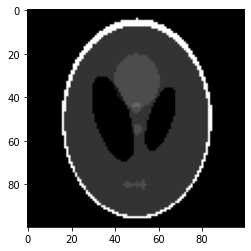

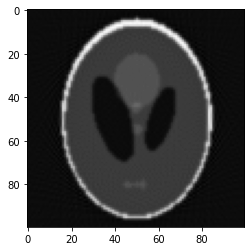

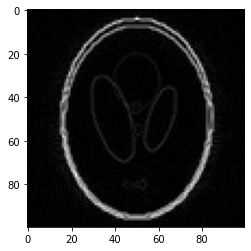

0.4740678191218022


In [280]:
plt.imshow(shepp,cmap='gray')
plt.show()
plt.imshow(recon,cmap='gray')
plt.show()

plt.imshow(abs(shepp-recon),cmap='gray')
plt.show()

print(np.max(abs(shepp-recon)))


In [262]:
def conj_grad_retrieval(projections,image_dimensions,detec_dim,num_angles,im_pix_wid,de_pix_wid):
    
#     de_pix_wid=im_pix_wid
    
    m = image_dimensions[0]
    n = image_dimensions[1]
    N = m*n
    
    guess = np.zeros((N,))
    
    k = int(np.floor(detec_dim*np.sqrt(2)) + 1)
    if k%2 == 1:
        k = k+1
        
    k = detec_dim
    
    xs = im_pix_wid*(0.5 + np.arange(int(-m/2),int(m/2)))
    xs= xs.reshape(1,m)
    xs = np.repeat(a = xs, repeats = n, axis = 0)
    xs = np.ndarray.flatten(xs)
    
    ys = im_pix_wid*(0.5 + np.arange(int(-n/2),int(n/2)))
    ys = ys.reshape(1,n)
    ys = np.repeat(a = ys, repeats = m, axis = 1)
    ys = np.ndarray.flatten(ys)
    
    ds = de_pix_wid*(0.5 + np.arange(int(-k/2),int(k/2)))
    phis = np.arange(0,num_angles)*np.pi/num_angles
    
    proj = np.zeros(num_angles*k)

    x_phi = xs*np.cos(phis[:,np.newaxis]) + ys*np.sin(phis[:,np.newaxis])
    p_phi = (np.floor(2*x_phi/de_pix_wid) + k - 1)/2
    p_phi = p_phi.astype(int)
    
    weight1 = np.zeros(np.shape(x_phi))
    
    for i in range(num_angles):
        for j in range(N):
            
            if p_phi[i,j] < detec_dim:
                weight1[i,j] = (ds[p_phi[i,j]] + de_pix_wid - x_phi[i,j])/de_pix_wid
    
    weight2 = np.zeros(np.shape(x_phi))
    weight2[weight1>0] = 1 - weight1[weight1>0]
    
    b = np.zeros((N,))
    
    #multiply b = A^t * projections
    for i in range(num_angles):
            for j in range(N):
                if p_phi[i,j] + 1 == np.size(ds):
                    b[j] += weight1[i,j]*projections[i*k + p_phi[i,j]]
                elif p_phi[i,j] + 1 < np.size(ds):
                    b[j] += weight1[i,j]*projections[i*k + p_phi[i,j]] + weight2[i,j]*projections[i*k + p_phi[i,j] + 1]
                    
    r_k = b 
    p_k = r_k 
    
    for it in range(30):
        print(f'iteration = {it}')
        Ap_k = np.zeros(np.shape(projections))
        AtAp_k = np.zeros((N,))
        
        #multiply p_k by A^tA for alpha and r_k+1
        for i in range(num_angles):
            for j in range(N):

                if p_phi[i,j] + 1 == np.size(ds):
                    Ap_k[i*k + p_phi[i,j]] += p_k[j]*weight1[i,j]
                elif p_phi[i,j] + 1 < np.size(ds):
                    Ap_k[i*k + p_phi[i,j]] += p_k[j]*weight1[i,j]
                    Ap_k[i*k + p_phi[i,j] + 1] += p_k[j]*weight2[i,j]
                    
        
        for i in range(num_angles):
            for j in range(N):
                if p_phi[i,j] + 1 == np.size(ds):
                    AtAp_k[j] += weight1[i,j]*Ap_k[i*k + p_phi[i,j]]
                elif p_phi[i,j] + 1 < np.size(ds):
                    AtAp_k[j] += weight1[i,j]*Ap_k[i*k + p_phi[i,j]] + weight2[i,j]*Ap_k[i*k + p_phi[i,j] + 1]
                    
        alpha = np.dot(r_k,r_k)/np.dot(p_k,AtAp_k)
        guess = guess + alpha*p_k
        r_kp1 = r_k - alpha*AtAp_k
        
        
        image = np.reshape(guess,(m,n),order='C')
        plt.imshow(image,cmap='gray')
        plt.show()
        
        print(np.dot(r_kp1,r_kp1)/np.dot(b,b))
        
        if np.dot(r_kp1,r_kp1) < np.dot(b,b)*1e-6:
            return guess
        
        beta = np.dot(r_kp1,r_kp1)/np.dot(r_k,r_k)
        p_k = r_kp1 + beta*p_k
        
        r_k = r_kp1
        
    print('didnt work :(')
    return guess

iteration = 0


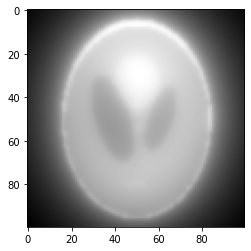

0.014755550793524138
iteration = 1


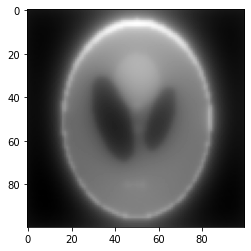

0.0031240645707840105
iteration = 2


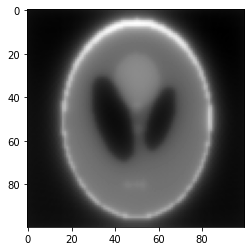

0.0014280190656741655
iteration = 3


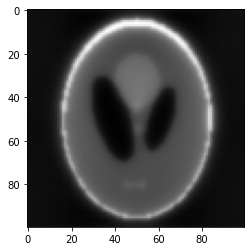

0.0005762479157470595
iteration = 4


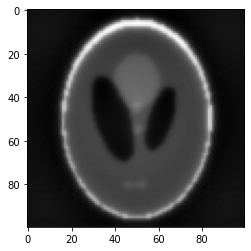

0.00019468210203728282
iteration = 5


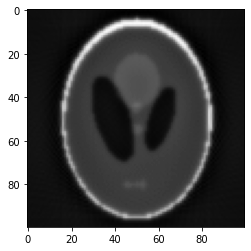

8.506874270244058e-05
iteration = 6


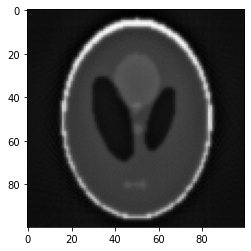

6.105341776479288e-05
iteration = 7


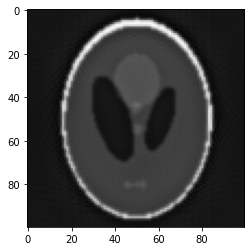

3.530079577359454e-05
iteration = 8


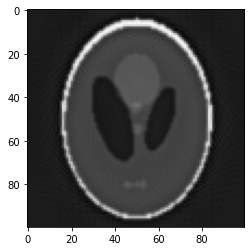

1.5176144796228334e-05
iteration = 9


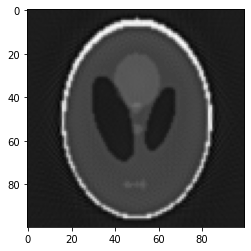

1.4320977560300781e-05
iteration = 10


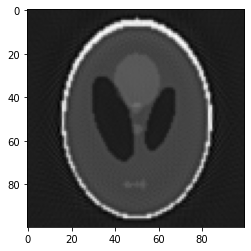

5.804590028845789e-06
iteration = 11


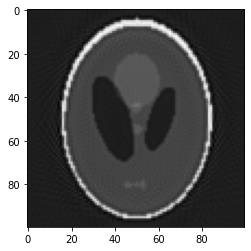

7.115356143778337e-06
iteration = 12


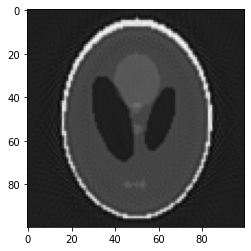

3.302529694738849e-06
iteration = 13


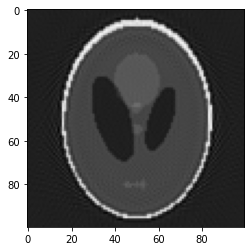

1.9272222081232493e-06
iteration = 14


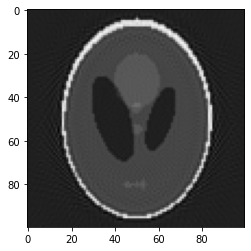

2.2370478976463877e-06
iteration = 15


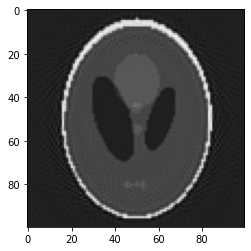

3.022983785463978e-06
iteration = 16


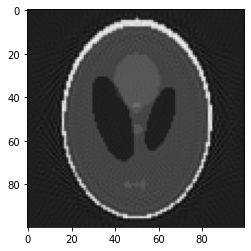

1.0330938966688392e-06
iteration = 17


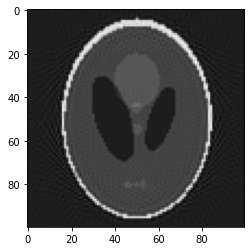

5.590725957245976e-07


In [281]:
recon2 = conj_grad_retrieval(projectionsflat,[m,m],2*m,T,im_pix_wid=1,de_pix_wid=1)
recon2 = np.reshape(recon2,(m,m),order='C')

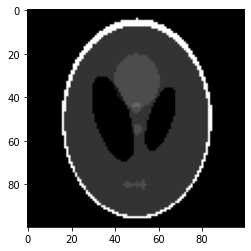

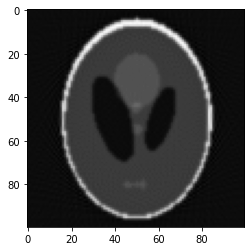

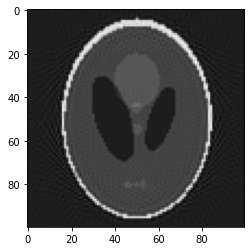

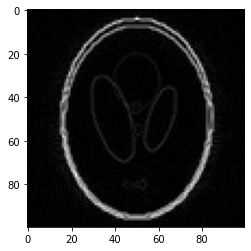

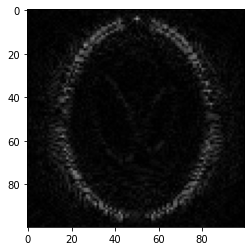

0.28796657623721933


In [282]:
plt.imshow(shepp,cmap='gray')
plt.show()
plt.imshow(recon,cmap='gray')
plt.show()
plt.imshow(recon2,cmap='gray')
plt.show()

plt.imshow(abs(shepp - recon),cmap='gray')
plt.show()

plt.imshow(abs(shepp-recon2),cmap='gray',vmax = np.max(abs(shepp - recon)))
plt.show()

print(np.max(abs(shepp-recon2)))

In [286]:
def sirt_retrieval(projections,image_dimensions,detec_dim,num_angles,im_pix_wid):
    
    de_pix_wid=im_pix_wid
    
    m = image_dimensions[0]
    n = image_dimensions[1]
    N = m*n
    
    guess = np.zeros((N,))
    
    k = int(np.floor(detec_dim*np.sqrt(2)) + 1)
    if k%2 == 1:
        k = k+1
        
    k = detec_dim
    
    xs = im_pix_wid*(0.5 + np.arange(int(-m/2),int(m/2)))
    xs= xs.reshape(1,m)
    xs = np.repeat(a = xs, repeats = n, axis = 0)
    xs = np.ndarray.flatten(xs)
    
    ys = im_pix_wid*(0.5 + np.arange(int(-n/2),int(n/2)))
    ys = ys.reshape(1,n)
    ys = np.repeat(a = ys, repeats = m, axis = 1)
    ys = np.ndarray.flatten(ys)
    
    ds = de_pix_wid*(0.5 + np.arange(int(-k/2),int(k/2)))
    phis = np.arange(0,num_angles)*np.pi/num_angles
    
    proj = np.zeros(num_angles*k)

    x_phi = xs*np.cos(phis[:,np.newaxis]) + ys*np.sin(phis[:,np.newaxis])
    p_phi = (np.floor(2*x_phi/de_pix_wid) + k - 1)/2
    p_phi = p_phi.astype(int)
    
    weight1 = np.zeros(np.shape(x_phi))
    
    
    for i in range(num_angles):
        for j in range(N):
            
            weight1[i,j] = (ds[p_phi[i,j]] + de_pix_wid - x_phi[i,j])/de_pix_wid
            
    weight2 = 1 - weight1
    
    
    
    R = np.zeros(np.shape(projections))
    C = np.zeros(np.shape(guess))
    
    
    for i in range(num_angles):
        for j in range(N):
            if p_phi[i,j] + 1 == np.size(ds):
                R[i*k + p_phi[i,j]] += weight1[i,j]
                C[j] += weight1[i,j]
            elif p_phi[i,j] + 1 < np.size(ds):
                R[i*k + p_phi[i,j]] += weight1[i,j]
                R[i*k + p_phi[i,j] + 1] += weight2[i,j]
                C[j] += weight1[i,j] + weight2[i,j]
    print(np.sum(R) - np.sum(C))
    R[R!=0] = 1/R[R!=0]
    C[C!=0] = 1/C[C!=0]
    
    lam = 1
    
    for step in range(50):
        print(f'iteration = {step}')
        
        proj = np.zeros(np.shape(projections))
        
        if step != 0:  
            
            #multiply by A
            
            for i in range(num_angles):
                for j in range(N):

                    if p_phi[i,j] + 1 == np.size(ds):
                        proj[i*k + p_phi[i,j]] += guess[j]*weight1[i,j]
                    elif p_phi[i,j] + 1 < np.size(ds):
                        proj[i*k + p_phi[i,j]] += guess[j]*weight1[i,j]
                        proj[i*k + p_phi[i,j] + 1] += guess[j]*weight2[i,j]


        r = projections - proj
        
        image = np.reshape(guess,(m,n),order='C')
        plt.imshow(image,cmap='gray')
        plt.show()
        
        print(np.sum(abs(r))/np.size(r))
        
        image_r = np.reshape(r,(k,num_angles),order='F')
        image_r = np.flip(image_r, axis=0)
        image_r = np.flip(image_r, axis=1)
        
        plt.imshow(abs(image_r),cmap='gray')
        plt.show()
        
        print(np.dot(r,r)/np.dot(projections,projections))

        if np.dot(r,r) < np.dot(projections,projections)*1e-3:
            return guess
        
        
        Rr = R*r
        
        
        direction = np.zeros((N,))

        #multiply by A^t
        for i in range(num_angles):
            for j in range(N):
                if p_phi[i,j] + 1 == np.size(ds):
                    direction[j] += weight1[i,j]*Rr[i*k + p_phi[i,j]]
                elif p_phi[i,j] + 1 < np.size(ds):
                    direction[j] += weight1[i,j]*Rr[i*k + p_phi[i,j]] + weight2[i,j]*Rr[i*k + p_phi[i,j] + 1]
        
        
        CAtRr = C*direction

        guess = guess + lam*CAtRr
        
        lam = lam*0.9

    print('didnt work :(')
    return guess

0.0
iteration = 0


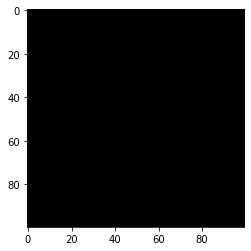

6.205039215686274


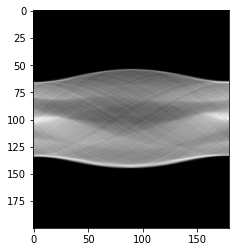

1.0
iteration = 1


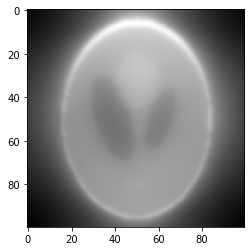

1.9384240238387227


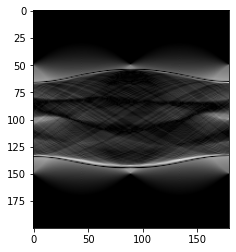

0.09666738034053986
iteration = 2


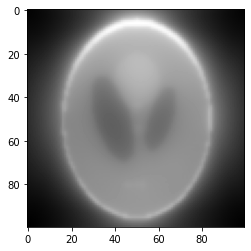

1.5682861545479192


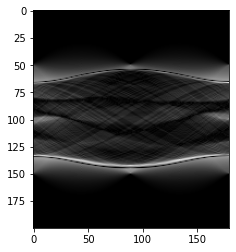

0.06842616815307752
iteration = 3


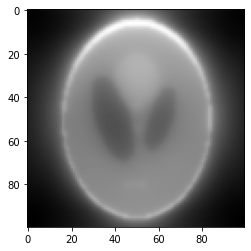

1.3325305752038443


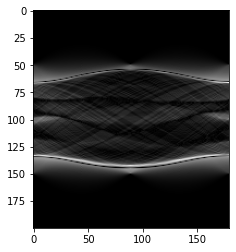

0.05370885644733943
iteration = 4


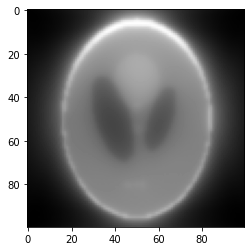

1.1720169165812426


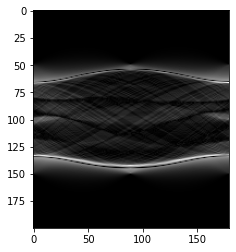

0.04493330809676109
iteration = 5


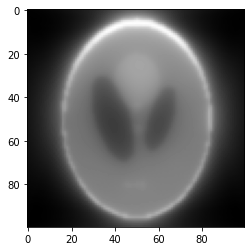

1.05737636286882


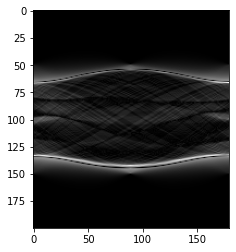

0.03917191456727749
iteration = 6


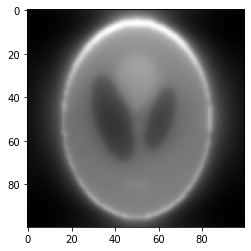

0.9723485723208852


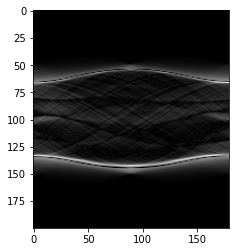

0.03512052263906825
iteration = 7


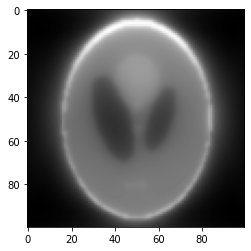

0.9076969653190166


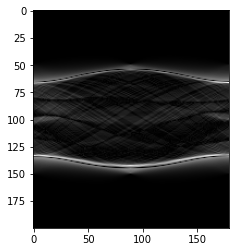

0.03212661207677359
iteration = 8


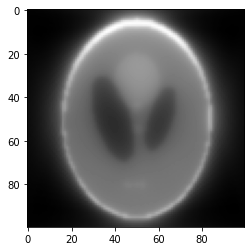

0.8575764978622903


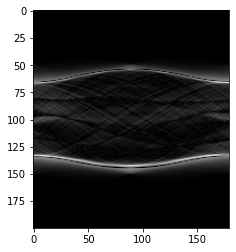

0.0298315676483365
iteration = 9


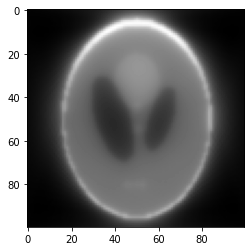

0.8176254764417693


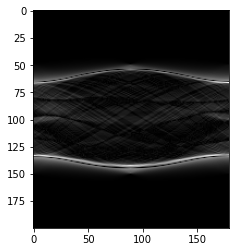

0.028022811818412402
iteration = 10


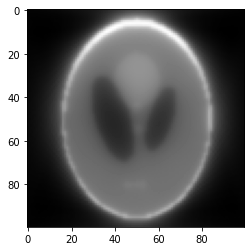

0.7851068295365135


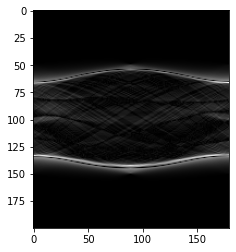

0.026566400486189735
iteration = 11


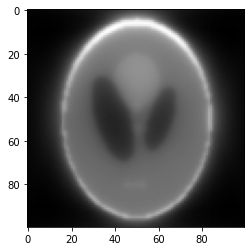

0.75826083048012


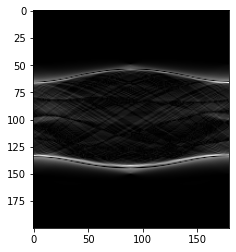

0.02537364742375195
iteration = 12


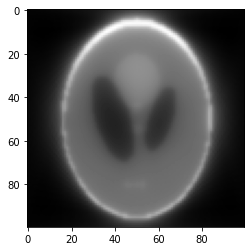

0.7358132462155734


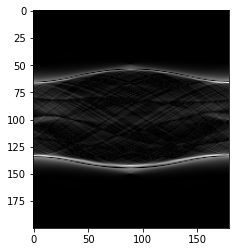

0.02438339985839992
iteration = 13


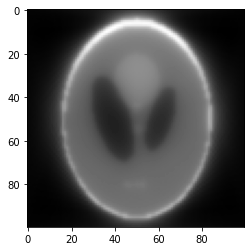

0.7168434713152885


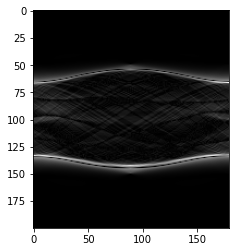

0.02355205026622474
iteration = 14


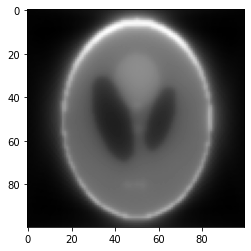

0.7007042748297243


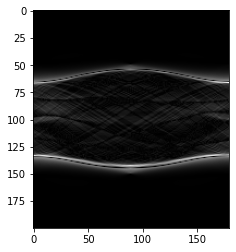

0.022847616447298522
iteration = 15


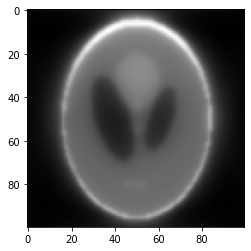

0.6868553754327268


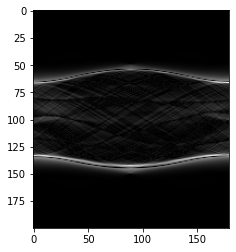

0.022246078350342785
iteration = 16


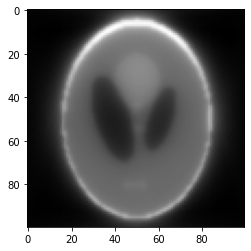

0.6748999553415734


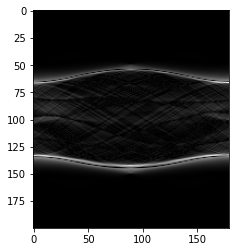

0.021729025917379952
iteration = 17


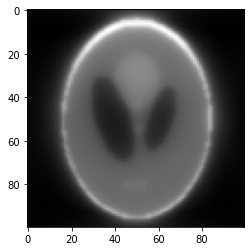

0.6645362462426428


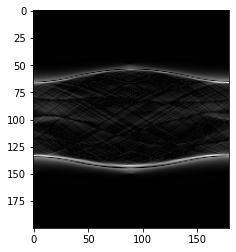

0.021282099692978663
iteration = 18


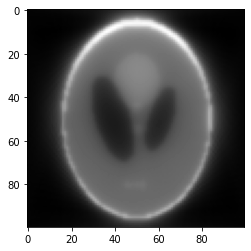

0.6555162597673018


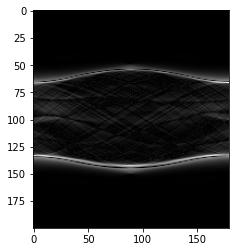

0.02089392786618638
iteration = 19


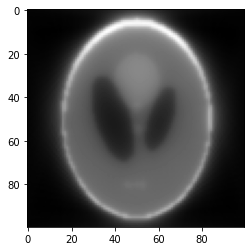

0.647628481378924


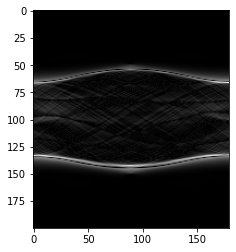

0.020555383851311226
iteration = 20


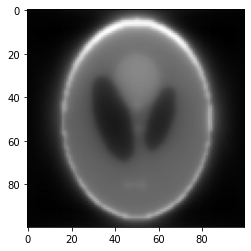

0.6407096658578398


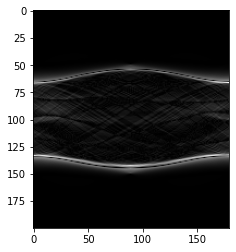

0.020259056497170018
iteration = 21


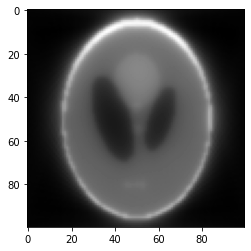

0.6346236204637816


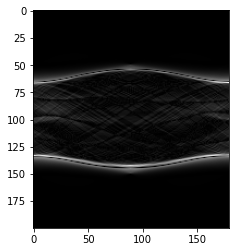

0.01999886475479367
iteration = 22


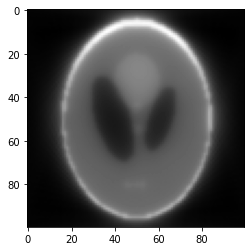

0.6292621656153671


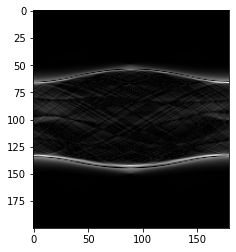

0.019769772600742825
iteration = 23


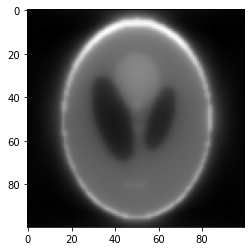

0.6245215913415735


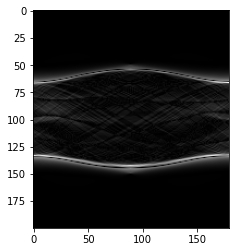

0.01956757487744896
iteration = 24


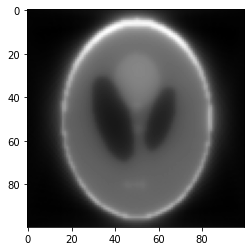

0.6203234001029916


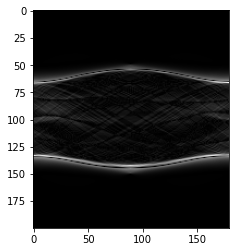

0.01938873416535277
iteration = 25


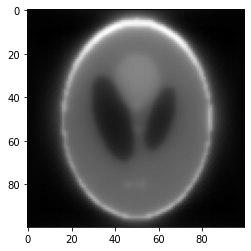

0.6165983119957392


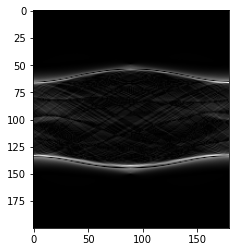

0.019230254951659614
iteration = 26


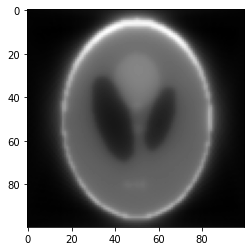

0.6132895869428376


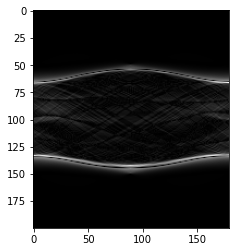

0.019089585444581936
iteration = 27


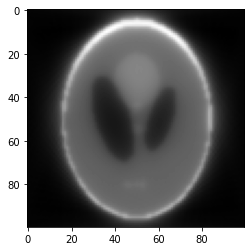

0.6103471777955146


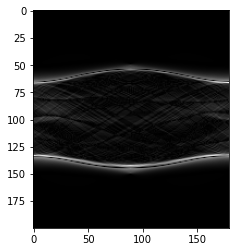

0.018964540145125646
iteration = 28


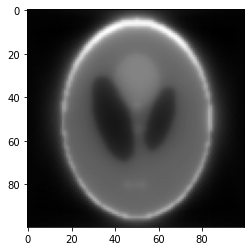

0.607726401243835


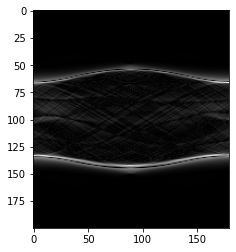

0.01885323819009075
iteration = 29


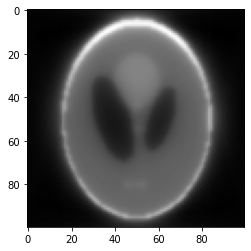

0.6053902479498657


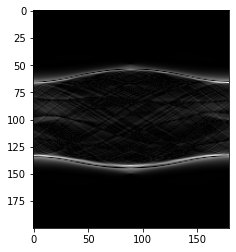

0.018754053809177506
iteration = 30


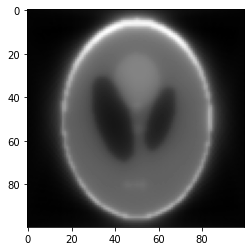

0.6033058877938912


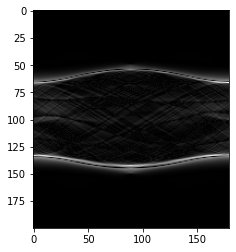

0.0186655761815863
iteration = 31


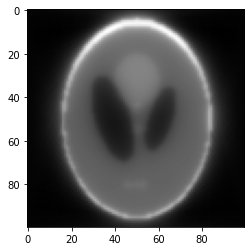

0.6014451588380518


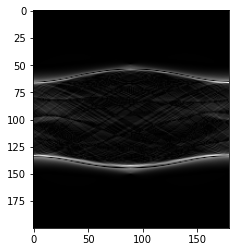

0.018586576654634354
iteration = 32


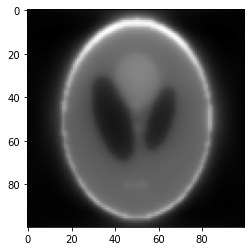

0.5997811700750448


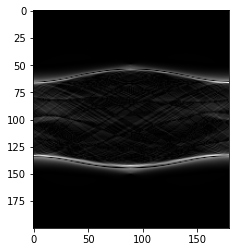

0.01851598177934427
iteration = 33


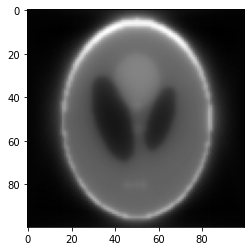

0.5982922517223705


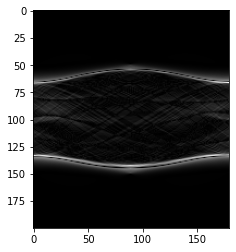

0.018452850980118448
iteration = 34


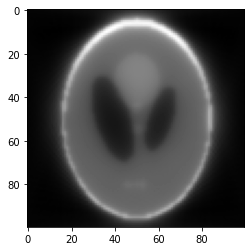

0.5969595180838453


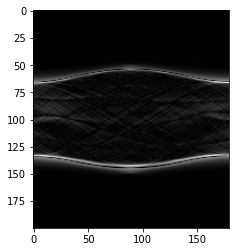

0.01839635794475783
iteration = 35


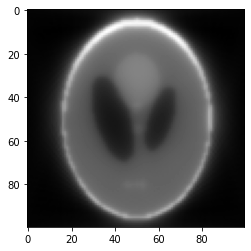

0.595766474687325


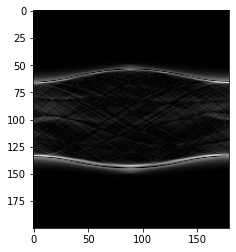

0.018345775023055677
iteration = 36


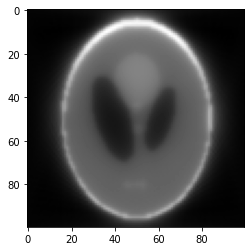

0.594697696659627


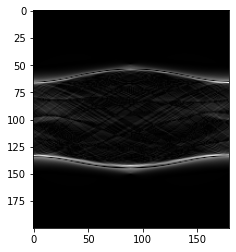

0.0183004600751425
iteration = 37


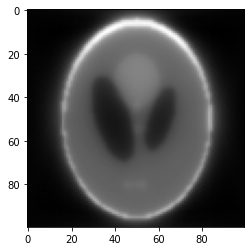

0.5937394643786627


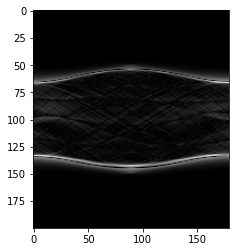

0.01825984532756531
iteration = 38


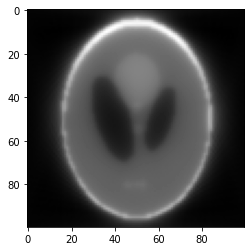

0.5928800461719731


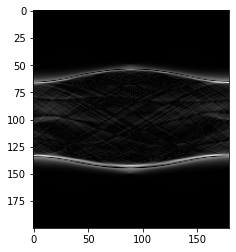

0.018223427885006093
iteration = 39


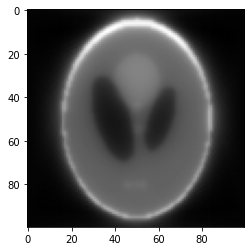

0.5921087543511924


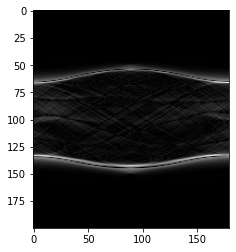

0.018190761615290783
iteration = 40


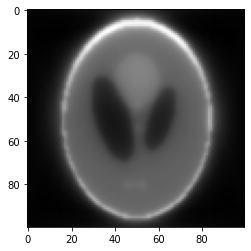

0.5914166615604327


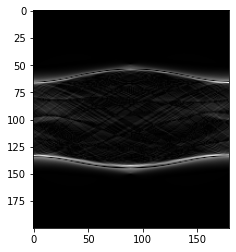

0.01816145017982257
iteration = 41


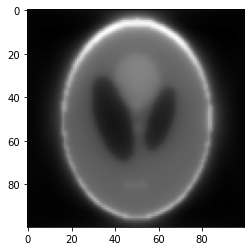

0.5907952996799725


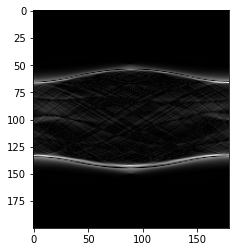

0.018135141024420334
iteration = 42


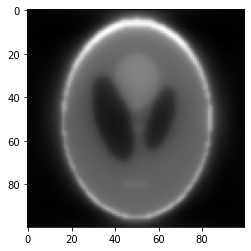

0.5902373302313465


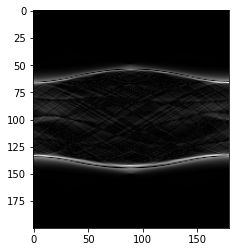

0.01811152017945487
iteration = 43


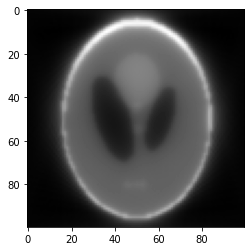

0.5897361381186642


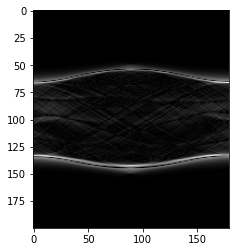

0.01809030774518047
iteration = 44


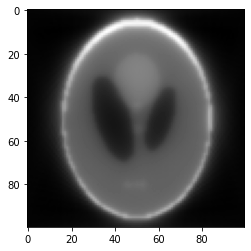

0.5892859306560638


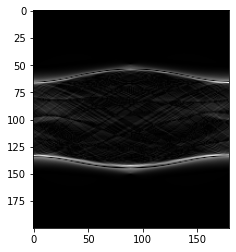

0.018071253959789802
iteration = 45


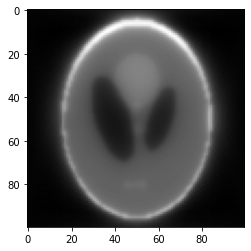

0.588881538932474


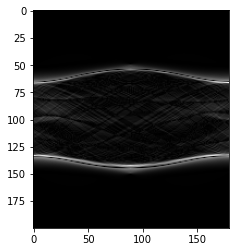

0.01805413576514314
iteration = 46


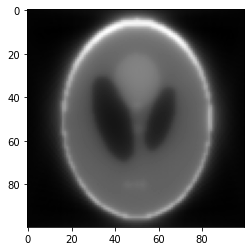

0.5885182364162447


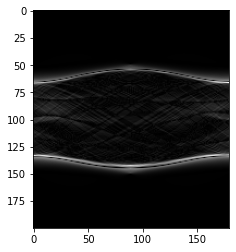

0.01803875379923315
iteration = 47


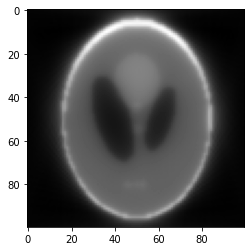

0.5881917403214478


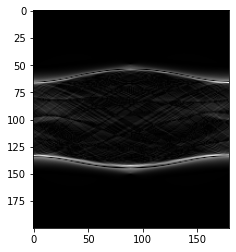

0.018024929755933335
iteration = 48


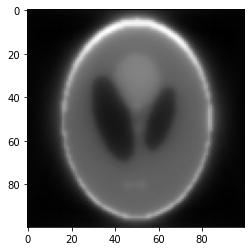

0.5878983995511077


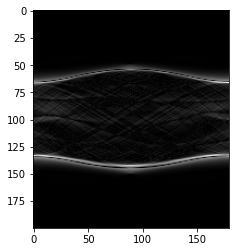

0.018012504061976888
iteration = 49


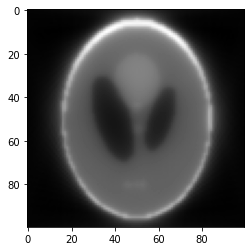

0.5876347408363245


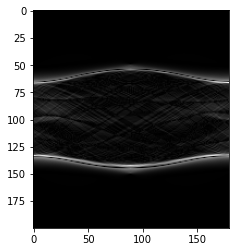

0.018001333828840584
didnt work :(


In [287]:
recon3 = sirt_retrieval(projectionsflat,[m,m],2*m,T,im_pix_wid=1)
recon3 = np.reshape(recon3,(m,m),order='C')

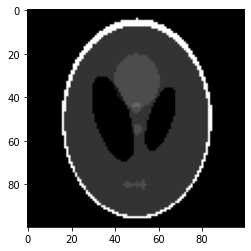

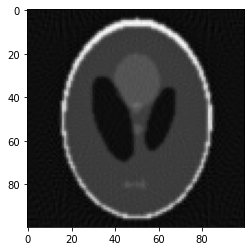

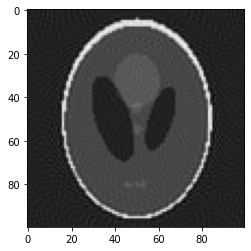

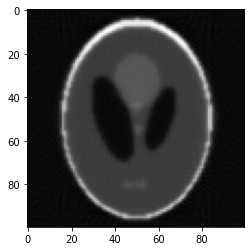

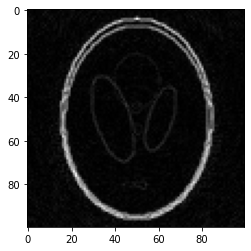

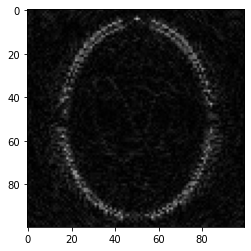

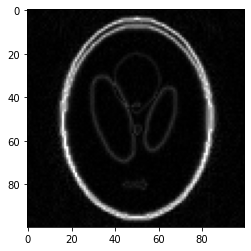

0.3565071746651368
0.5402825078994024


In [273]:
plt.imshow(shepp,cmap='gray')
plt.show()
plt.imshow(recon,cmap='gray')
plt.show()
plt.imshow(recon2,cmap='gray')
plt.show()
plt.imshow(recon3,cmap='gray')
plt.show()

plt.imshow(abs(shepp - recon),cmap='gray')
plt.show()

plt.imshow(abs(shepp-recon2),cmap='gray',vmax = np.max(abs(shepp - recon)))
plt.show()

plt.imshow(abs(shepp-recon3),cmap='gray',vmax = np.max(abs(shepp - recon)))
plt.show()

print(np.max(abs(shepp-recon2)))

print(np.max(abs(shepp-recon3)))